In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime
from torchvision.transforms import transforms 
from torchvision.utils import make_grid
import torch.nn as nn
import time
import os
import copy
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/6r/r5dfhtxd75g2p4pkybxl8jcc0000gn/T/ipykernel_76332/1205883626.py:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
# local data_dir 
# data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
model_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/"
# train/val/test dir CHANGE TO 64 or 255
data_file_path = data_dir + "/preprocessed_data/train_64_noreroofs_bias.npy"
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"
val_data_file_path = data_dir + "/preprocessed_data/val_64_noreroofs.npy"

In [3]:
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils")
from data import ImageDataset

In [4]:
# import Roofnet
# from Roofnet.utils.data import ImageDataset
from torchvision.transforms import transforms 


transform_chain = transforms.Compose([
                        transforms.ToPILImage(mode='RGB'),
                        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
data = ImageDataset(data_file_path,
                    transform=transform_chain)
dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
len(data), len(dataloader)


Loading data
Done loading data
Length 1050
Num Roofs 150


(1050, 33)

In [5]:
sample = data[0]  # get a sample from the dataset
print(type(sample))
print(len(sample))  # check the length of the tuple
print(sample[0])  # check the shape of the image tensor

<class 'tuple'>
3
tensor([[[0.4235, 0.4039, 0.3843,  ..., 0.2118, 0.2667, 0.3059],
         [0.4549, 0.4549, 0.4353,  ..., 0.2157, 0.2118, 0.2980],
         [0.4353, 0.4549, 0.4549,  ..., 0.2235, 0.2314, 0.2588],
         ...,
         [0.1882, 0.1843, 0.1843,  ..., 0.2314, 0.2863, 0.2902],
         [0.2510, 0.2667, 0.2549,  ..., 0.2510, 0.2824, 0.2902],
         [0.4353, 0.4392, 0.4275,  ..., 0.2392, 0.2431, 0.2196]],

        [[0.4353, 0.4157, 0.4039,  ..., 0.1961, 0.2627, 0.3216],
         [0.4627, 0.4706, 0.4510,  ..., 0.2000, 0.1961, 0.3059],
         [0.4510, 0.4667, 0.4588,  ..., 0.2039, 0.2118, 0.2431],
         ...,
         [0.1882, 0.1882, 0.1961,  ..., 0.2275, 0.2745, 0.2824],
         [0.2510, 0.2667, 0.2667,  ..., 0.2510, 0.2706, 0.2784],
         [0.4431, 0.4392, 0.4275,  ..., 0.2353, 0.2353, 0.2196]],

        [[0.4235, 0.4039, 0.3843,  ..., 0.1922, 0.2431, 0.2824],
         [0.4549, 0.4549, 0.4353,  ..., 0.1961, 0.1843, 0.2667],
         [0.4275, 0.4471, 0.4431,  ..., 

In [6]:
# Fixed input for debugging
fixed_x = next(iter(dataloader))
fixed_x = fixed_x[0]
print(fixed_x.shape)
# torch.Size([32, 3, 255, 255]) or torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])


In [7]:
# Set default parameters
image_channels = fixed_x.size(1)

img_dim = fixed_x.size(-1)
print(img_dim)

64


In [8]:
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/models")
from vae import VAE


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(img_dim = img_dim, image_channels=image_channels, z_dim=128,device=device).to(device)

In [10]:
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load('/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/roofnet_VAE_64_1.pth'))
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1024, bias=True)
)

# Build binary classifier on latents

In [11]:
from torch.autograd import Variable

## Helper functions:

In [12]:
# Inputs: latent image 1, latent image 2, classification model, and prob threshold
# Returns binary classification, 1 for reroof, 0 for none.
# classifying two images as reroof if the probability is greater than the threshold

def classify_image_pair(latent_1,latent_2,model,prob_threshold=0.5):    # model is the classification model
    v_1 = np.hstack((latent_1,latent_2)) # concatenate the two latent vectors
    v_2 = np.hstack((latent_2,latent_1)) # concatenate the two latent vectors
    model.eval()
    p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
    p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
    prob = max([p_1.item(),p_2.item()]) # take the max probability
    return prob >= prob_threshold # return 1 if the probability is greater than the threshold, 0 otherwise

In [13]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on first transition detected
# If no transition detected, returns 0
def gen_predictions(latents,meta,model,prob_threshold=0.5): 
    out = [] 
    for i in range(len(latents)): # for each building
        hold = [] # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0])) # append the address
        trans_year = 0 # initialize the transition year
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            if classify_image_pair(latents[i][j],latents[i][j+1],model,prob_threshold=prob_threshold): # if the pair is classified as a reroof
                trans_year = j + 2013   # set the transition year to the year of the pair
                break
        hold.append(trans_year)  # append the transition year
        hold.append(int(meta[i][1])) # append the actual transition year
        out.append(hold) # append the list to the output
    return np.array(out) # return the output as an array

In [14]:
# Input: Latents for a building, meta for building, model, and threshold
# Output: [Address, predicted_transition, actual_transition]
# Returns transition year based on highest probability
# If no transition detected, returns 0
def get_max_prob(latents,meta,model,prob_threshold=0.5): 
    out = []
    for i in range(len(latents)): # for each building
        hold = []  # hold the address, predicted transition year, and actual transition year
        hold.append(str(meta[i][0]))   # append the address
        trans_year = 0
        temp = [] # hold the probabilities
        for j in range(len(latents[i])-1): # for each pair of latent vectors
            latent_1 = latents[i][j] # get the latent vectors
            latent_2 = latents[i][j+1] # get the latent vectors
            v_1 = np.hstack((latent_1,latent_2)) # concatenate the latent vectors
            v_2 = np.hstack((latent_2,latent_1)) # concatenate the latent vectors
            model.eval()
            p_1 = net(torch.tensor(v_1).to(device)) # pass the concatenated latent vectors to the classification model
            p_2 = net(torch.tensor(v_2).to(device)) # pass the concatenated latent vectors to the classification model
            prob = max([p_1.item(),p_2.item()]) # take the max probability
            temp.append(prob) # append the probability
        index = np.argmax(temp)     # get the index of the max probability
        if temp[index]>=prob_threshold: # if the max probability is greater than the threshold
            trans_year = 2013 + index # set the transition year to the year of the max probability 
        hold.append(trans_year) # append the transition year
        hold.append(int(meta[i][1]))       # append the actual transition year
        out.append(hold)    # append the list to the output
    return np.array(out)    # return the output as an array

In [15]:
# Generates accuracy metrics for detecting reroof and predicting reroof date
# No reroof is defined as a building that has no reroof in the dataset
# Reroof is defined as a building that has a reroof in the dataset
def gen_metrics(acc_metric, latents, meta, model, threshold=0.5):   
    no_reroof_pred = [] # hold the predictions for buildings with no reroof
    reroof_pred = [] # hold the predictions for buildings with a reroof
    hold = acc_metric(latents,meta, net ,threshold) # get the predictions
    print("Overall accuracy: {:0.3f}".format(np.mean(hold[:,1]==hold[:,2]))) # print the overall accuracy
    for i in hold: # for each building
        if int(i[2])==0:    # if the building has no reroof
            no_reroof_pred.append(int(int(i[1]) == 0))      # append the prediction
        else:
            reroof_pred.append(int(i[1]==i[2]))         # append the prediction
    print("No reroof prediction accuracy: {:0.3f}".format(np.mean(no_reroof_pred)))
    print("Reroof prediction accuracy: {:0.3f}".format(np.mean(reroof_pred)))
    return hold

In [16]:
# Inputs: file path for data
# Outputs: Dataloader for training

def gen_dataloader(data_file_path):     
    transform_chain = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.,0.,0,], [1.,1.,1.]),   
                        
                            ])
    data = ImageDataset(data_file_path,
                        transform=transform_chain)

    dataloader = torch.utils.data.DataLoader(data, batch_size=7, shuffle=False)
    dataloader = iter(dataloader)
    return dataloader

In [17]:
# Input: dataloader, latent generating model
# Outputs: Latents generate by model, meta data for buildings
# Generates latents for all buildings in dataloader
def gen_latents(dataloader, model): # generate latents for all buildings in dataloader
    latents = [] # hold the latents for the buildings
    meta = [] # hold the meta data for the buildings
    for i in dataloader: # for each building
        images = i[0] # get the images
        _, z, _, _ = model(images.to(device)) # get the latents
        z = z.detach().cpu().numpy()    # detach the latents in order to append to list
        latents.append(z)  # append the latents
        meta.append([i[2]['address'][0],int(i[2]['transition_year'][0].cpu().numpy())])     # append the meta data
    latents = np.array(latents)     # convert the latents to an array
    return latents, meta    

In [18]:
# Inputs: Latents of data, meta for building
# Output: All possible pairs of latent images and their label 1:reroof, 0:no reroof
# Generates all possible pairs of latent images and their label 1:reroof, 0:no reroof
# Used for training binary classifier

def gen_binary_data(latents, meta):         # generate all possible pairs of latent images and their label 1:reroof, 0:no reroof
    data_hold = []  # hold the latent pairs
    label_hold = []     # hold the labels
    for i in range(len(latents)):   # for each building
        for j in range(len(latents[i])):    # for each latent vector
            for k in range(len(latents[i])):        # for each latent vector
                data_hold.append(np.hstack((latents[i][j],latents[i][k])))      # append the latent pair
                year_j = 2012+j < meta[i][1]        # get the year of the latent vector
                year_k = 2012+k < meta[i][1]        # get the year of the latent vector
                label_hold.append(float(year_j != year_k))    # append the label
    data_hold = np.array(data_hold)     # convert the data to an array
    label_hold = np.array(label_hold)   # convery the labels to an array
    
    return data_hold, label_hold

## Load the data

In [19]:
# z_dim = 128 is the dimension of the latent space
model = VAE(img_dim=64,image_channels=image_channels,z_dim=128,device=device).to(device)
model.load_state_dict(torch.load(model_dir + 'roofnet_VAE_64_1.pth'))
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/"
data_file_path = data_dir + "preprocessed_data/train_64_noreroofs.npy"

binary_dataloader = gen_dataloader(data_file_path)

Loading data
Done loading data
Length 1050
Num Roofs 150


In [20]:
val_data_file_path = data_dir + "preprocessed_data/val_64_noreroofs.npy"

binary_val_dataloader = gen_dataloader(val_data_file_path)

Loading data
Done loading data
Length 175
Num Roofs 25


In [21]:
test_data_file_path = data_dir + "/preprocessed_data/test_64_noreroofs.npy"

binary_test_dataloader = gen_dataloader(test_data_file_path)

Loading data
Done loading data
Length 385
Num Roofs 55


In [22]:
latents, meta = gen_latents(binary_dataloader, model)
print(latents.shape)

(150, 7, 128)


In [23]:
val_latents, val_meta = gen_latents(binary_val_dataloader, model)
print(val_latents.shape)

(25, 7, 128)


In [24]:
test_latents, test_meta = gen_latents(binary_test_dataloader, model)

In [25]:
data_hold, label_hold = gen_binary_data(latents, meta)

In [26]:
val_hold, val_label = gen_binary_data(val_latents, val_meta)
print(val_hold.shape)

(1225, 256)


In [27]:
test_hold, test_label = gen_binary_data(test_latents, test_meta)
print(test_hold.shape)
print(test_hold)

(2695, 256)
[[ 0.4801423   0.67580223 -0.45657098 ... -0.42439705 -0.45513332
   0.33753806]
 [ 0.4801423   0.67580223 -0.45657098 ...  0.24422471 -0.17582072
  -0.0831211 ]
 [ 0.4801423   0.67580223 -0.45657098 ... -0.42096525 -0.33332992
   0.34960288]
 ...
 [-0.10192408  0.05119662 -0.07207674 ...  0.14892617  0.07879492
  -0.14295638]
 [-0.10192408  0.05119662 -0.07207674 ...  0.044833    0.06175151
  -0.13726197]
 [-0.10192408  0.05119662 -0.07207674 ...  0.02722042  0.06148326
  -0.06004282]]


## Normalization Inspection

In [28]:
mean_val = test_hold.mean()
std_val = test_hold.std()
min_val = test_hold.min()
max_val = test_hold.max()

print(f"Mean: {mean_val}")
print(f"Standard Deviation: {std_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")


Mean: 0.001060481183230877
Standard Deviation: 0.6289908289909363
Min: -7.353736877441406
Max: 7.017803192138672


In [29]:

data = test_hold

means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0)

# Checking the conditions
is_zero_mean = np.allclose(means, np.zeros_like(means), atol=1e-5)
is_unit_variance = np.allclose(std_devs, np.ones_like(std_devs), atol=1e-5)

if is_zero_mean and is_unit_variance:
    print("The data is normalized.")
else:
    print("The data is not normalized.")
    if not is_zero_mean:
        print("The mean of some features is not approximately zero.")
    if not is_unit_variance:
        print("The standard deviation of some features is not approximately one.")


The data is not normalized.
The mean of some features is not approximately zero.
The standard deviation of some features is not approximately one.


In [30]:
if 0 <= min_val and max_val <= 1:
    print("Data is likely normalized between 0 and 1.")
else:
    print("Data does not appear to be Min-Max normalized between 0 and 1.")


Data does not appear to be Min-Max normalized between 0 and 1.


In [31]:
import numpy as np

import numpy as np


data = test_hold  # Placeholder for your data

# Calculate the mean and standard deviation for each feature
means = np.mean(data, axis=0)
std_devs = np.std(data, axis=0)

# Z-score normalization
normalized_data = (data - means) / std_devs


In [32]:
means = np.mean(normalized_data, axis=0)
std_devs = np.std(normalized_data, axis=0)

# Checking the conditions
is_zero_mean = np.allclose(means, np.zeros_like(means), atol=1e-5)
is_unit_variance = np.allclose(std_devs, np.ones_like(std_devs), atol=1e-5)

if is_zero_mean and is_unit_variance:
    print("The data is normalized.")
else:
    print("The data is not normalized.")
    if not is_zero_mean:
        print("The mean of some features is not approximately zero.")
    if not is_unit_variance:
        print("The standard deviation of some features is not approximately one.")
print(normalized_data)

The data is normalized.
[[ 9.94490564e-01  1.37894583e+00 -8.31492424e-01 ... -1.19482434e+00
  -1.06923389e+00  4.38800484e-01]
 [ 9.94490564e-01  1.37894583e+00 -8.31492424e-01 ...  2.07578674e-01
  -4.92054194e-01 -2.21655697e-01]
 [ 9.94490564e-01  1.37894583e+00 -8.31492424e-01 ... -1.18762624e+00
  -8.17535758e-01  4.57742870e-01]
 ...
 [-1.19615205e-01  1.55135140e-01  1.97622731e-01 ...  7.69441808e-03
   3.40909362e-02 -3.15600127e-01]
 [-1.19615205e-01  1.55135140e-01  1.97622731e-01 ... -2.10636139e-01
  -1.12806424e-03 -3.06659609e-01]
 [-1.19615205e-01  1.55135140e-01  1.97622731e-01 ... -2.47577727e-01
  -1.68236985e-03 -1.85421646e-01]]


In [35]:
# check feature 1 for normalization
mean_first_feature = np.mean(normalized_data[:, 0])
std_dev_first_feature = np.std(normalized_data[:, 0])

print("Mean of the first feature:", mean_first_feature)
print("Standard deviation of the first feature:", std_dev_first_feature)



Mean of the first feature: -7.643549e-08
Standard deviation of the first feature: 0.999999


## Load the model

In [36]:
class Net(nn.Module): # binary classifier
    
    def __init__(self, zdim = 128): # initialize network # zdim is the dimension of the latent vector
        super().__init__()  # inherit from nn.Module
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    # get device
        
        self.network = nn.Sequential( # define network
            nn.Linear(2*zdim, 2*zdim), # input layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(2*zdim, zdim),   # hidden layer
            nn.ReLU(), # activation function
            nn.Dropout(0.2),   # dropout
            nn.Linear(zdim, 64),    # hidden layer
            nn.ReLU(),  # activation function
            nn.Dropout(0.2),    # dropout
            nn.Linear(64, 1),   # output layer
            nn.Sigmoid()    # sigmoid function
        ).to(self.device)       # send network to device
              
    
    def forward(self, x):
        y = self.network(x)    # forward pass
        return y   # return output of network (prediction)
    
net = Net()    
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()    # binary cross entropy loss



# Evaluation

## Finding Noise

In [37]:
import numpy as np


print("Minimum value in test_hold:", np.min(normalized_data))
print("Maximum value in test_hold:", np.max(normalized_data))


Minimum value in test_hold: -6.081886
Maximum value in test_hold: 6.83538


In [38]:
# Given values
min_value = 0.0
max_value = 1.0

# Calculate range
data_range = max_value - min_value

# Set noise_std_dev as a fraction of the range
x = 10
noise_std_dev = data_range / x

print("Standard Deviation of Noise:", noise_std_dev)


Standard Deviation of Noise: 0.1


In [39]:
data_range = max_value - min_value

for noise_percentage in [0.01, 0.10, 0.25, 0.50]:  # 1%, 10%, 25%, and 50% of the data range
    noise_std_dev = data_range * noise_percentage
    print(f'Noise standard deviation for {noise_percentage*100:.0f}% of the data range: {noise_std_dev:.4f}')


Noise standard deviation for 1% of the data range: 0.0100
Noise standard deviation for 10% of the data range: 0.1000
Noise standard deviation for 25% of the data range: 0.2500
Noise standard deviation for 50% of the data range: 0.5000


# Models' Robustness

## Robustness with Data Interpolation

### Simple Accuracy Score for # amount of iterations

In [40]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5301posneg.pth', 'roofnet_binary_class_avg5303pos.pth', 'roofnet_binary_class_avg5303neg.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Interpolation with noise
def interpolate_with_noise(data, r):
    noise = np.random.randn(*data.shape)
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r):
    interpolated_data = interpolate_with_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Robustness analysis
def robustness_analysis_using_interpolation(data, labels, models, model_names, device, r_values=np.linspace(0, 1, 10), n_iterations=100):
    model_accuracies = {}
    model_variances = {}
    
    for model, name in zip(models, model_names):
        all_accuracies = []

        for r in r_values:
            accuracies_for_r = []
            for _ in range(n_iterations):
                accuracy = evaluate_model_on_interpolated_data(data, labels, model, device, r)
                accuracies_for_r.append(accuracy)
            all_accuracies.append(accuracies_for_r)

        mean_accuracies = np.mean(all_accuracies, axis=1)
        variance_accuracies = np.var(all_accuracies, axis=1)

        model_accuracies[name] = mean_accuracies
        model_variances[name] = variance_accuracies

    # Plotting accuracies
    plt.figure(figsize=(10, 6))
    for name, accuracies in model_accuracies.items():
        plt.plot(r_values, accuracies, label=name)
    plt.title("Mean Accuracies")
    plt.xlabel("Interpolation Factor r")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True) 
    plt.show()

    # Plotting accuracy variances
    plt.figure(figsize=(10, 6))
    for name, variances in model_variances.items():
        plt.plot(r_values, variances, label=name)
    plt.title("Accuracy Variances")
    plt.xlabel("Interpolation Factor r")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True) 
    plt.show()



In [43]:
# Assuming test_hold and test_label are defined and contain the test data and labels
robustness_analysis_using_interpolation(normalized_data, test_label, models, model_names, device)

KeyboardInterrupt: 

## Iteration through model runs, random noise

['binary_classifier_shap_variance_aplha02', 'binary_classifier_shap_negative_dynamic_aplha02', 'binary_classifier_shap_positive_dynamic_aplha02', 'binary_classifier_sota_2', 'binary_classifier_shap_dynamic_aplha02']


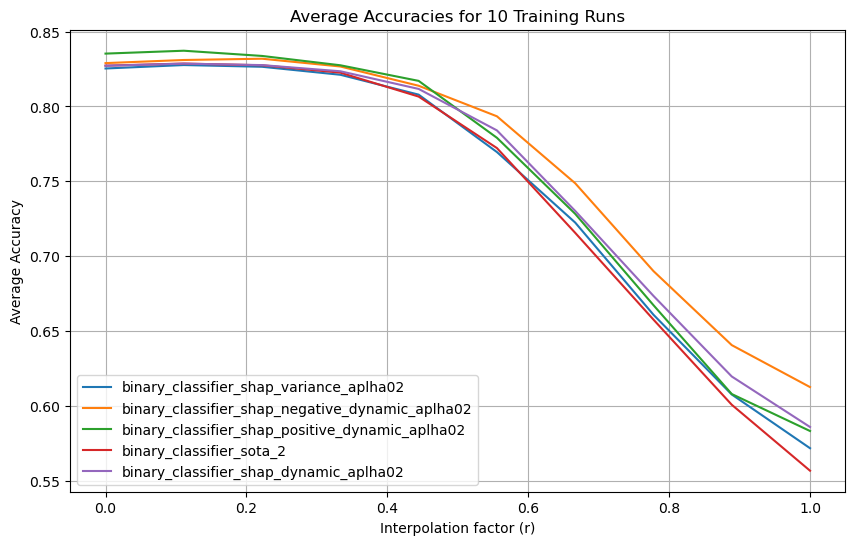

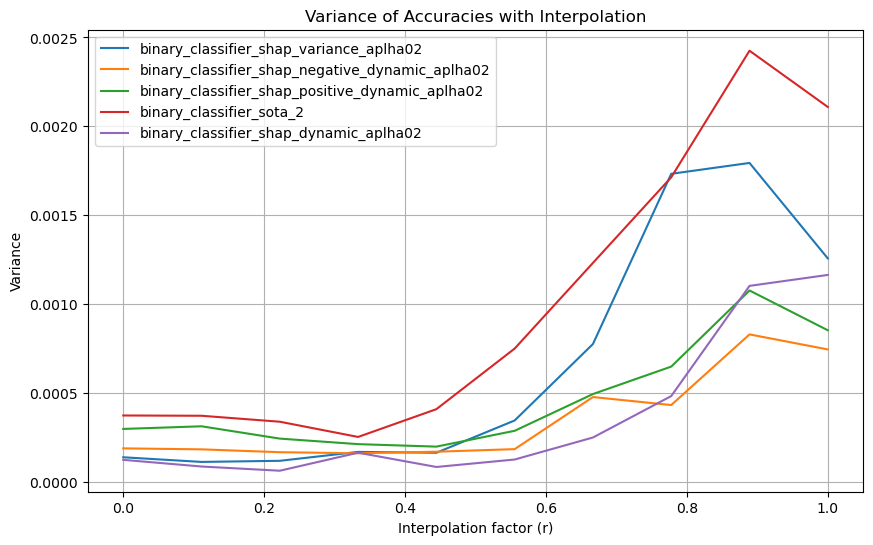

In [45]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Interpolation with noise
def interpolate_with_noise(data, r):
    # generate noise that has the same shape as the input data
    noise = np.random.randn(*data.shape)
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r):
    interpolated_data = interpolate_with_noise(data, r)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/dynamic_values"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)
results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for folder in model_folders:
    folder_path = os.path.join(base_dir, folder)
    accuracies_for_r = []
    variances_for_r = []

    for r in r_values:
        accuracies = []

        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)

            accuracy = evaluate_model_on_interpolated_data(normalized_data, test_label, model, device, r)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value
        accuracies_for_r.append(np.mean(accuracies))
        variances_for_r.append(np.var(accuracies))
    
    # Store the results for this model type
    results[folder] = accuracies_for_r
    variances[folder] = variances_for_r

# Plot the average accuracies
plt.figure(figsize=(10, 6))
for model_type, accuracies in results.items():
    plt.plot(r_values, accuracies, label=model_type)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy")
plt.legend()
plt.grid(True)
plt.title("Average Accuracies for 10 Training Runs")
plt.show()

# Plot the variances
plt.figure(figsize=(10, 6))
for model_type, variance in variances.items():
    plt.plot(r_values, variance, label=model_type)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies with Interpolation")
plt.show()


In [46]:
summary_stats = {}

for model_type, acc_scores in results.items():
    stats = {
        "Mean": np.mean(acc_scores),
        "Median": np.median(acc_scores),
        "Min": np.min(acc_scores),
        "Max": np.max(acc_scores),
        "IQR": np.percentile(acc_scores, 75) - np.percentile(acc_scores, 25)
    }
    summary_stats[model_type] = stats

# Print the summary statistics
for model, stats in summary_stats.items():
    print(f"Summary for {model}:")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
    print("------")


Summary for binary_classifier_shap_variance_aplha02:
Mean: 0.7441
Median: 0.7887
Min: 0.5716
Max: 0.8277
IQR: 0.1481
------
Summary for binary_classifier_shap_negative_dynamic_aplha02:
Mean: 0.7618
Median: 0.8036
Min: 0.6125
Max: 0.8319
IQR: 0.1238
------
Summary for binary_classifier_shap_positive_dynamic_aplha02:
Mean: 0.7516
Median: 0.7981
Min: 0.5831
Max: 0.8373
IQR: 0.1497
------
Summary for binary_classifier_sota_2:
Mean: 0.7415
Median: 0.7894
Min: 0.5566
Max: 0.8287
IQR: 0.1541
------
Summary for binary_classifier_shap_dynamic_aplha02:
Mean: 0.7512
Median: 0.7979
Min: 0.5858
Max: 0.8286
IQR: 0.1387
------


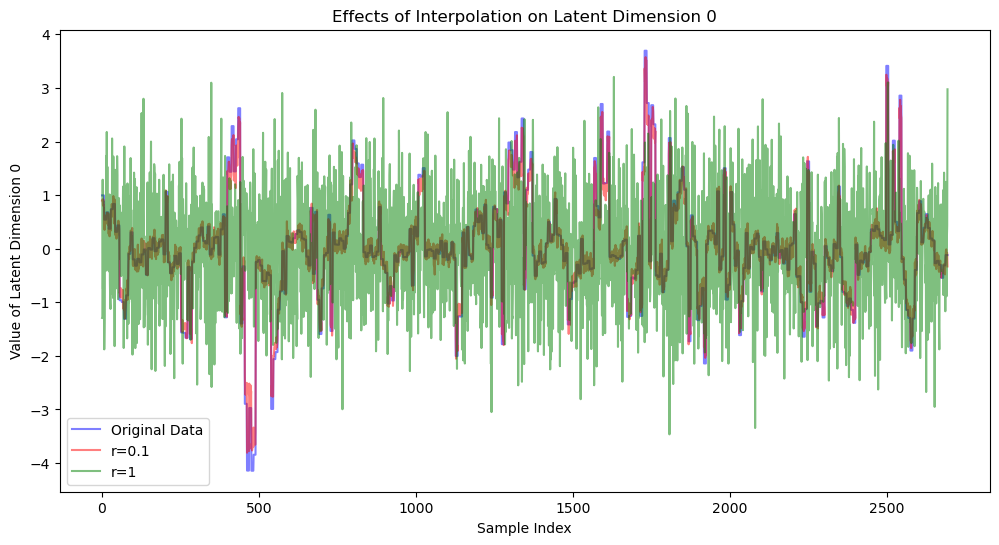

In [47]:
# Pick a specific latent dimension to visualize, for example, dimension 0
latent_dim = 0

plt.figure(figsize=(12, 6))

# Plot original data for this latent dimension
plt.plot(normalized_data[:, latent_dim], label="Original Data", color="blue", alpha=0.5)

# Plot data with different interpolation values
r_values = [0.1, 1]
colors = ["red", "green", "purple"]
for r, color in zip(r_values, colors):
    interpolated_data = interpolate_with_noise(normalized_data, r)
    plt.plot(interpolated_data[:, latent_dim], label=f"r={r}", color=color, alpha=0.5)

plt.legend()
plt.title(f"Effects of Interpolation on Latent Dimension {latent_dim}")
plt.xlabel("Sample Index")
plt.ylabel(f"Value of Latent Dimension {latent_dim}")
plt.show()


## Iteration through model runs, same noise

['binary_classifier_shap_variance_aplha02', 'binary_classifier_shap_negative_dynamic_aplha02', 'binary_classifier_shap_positive_dynamic_aplha02', 'binary_classifier_sota_2', 'binary_classifier_shap_dynamic_aplha02']


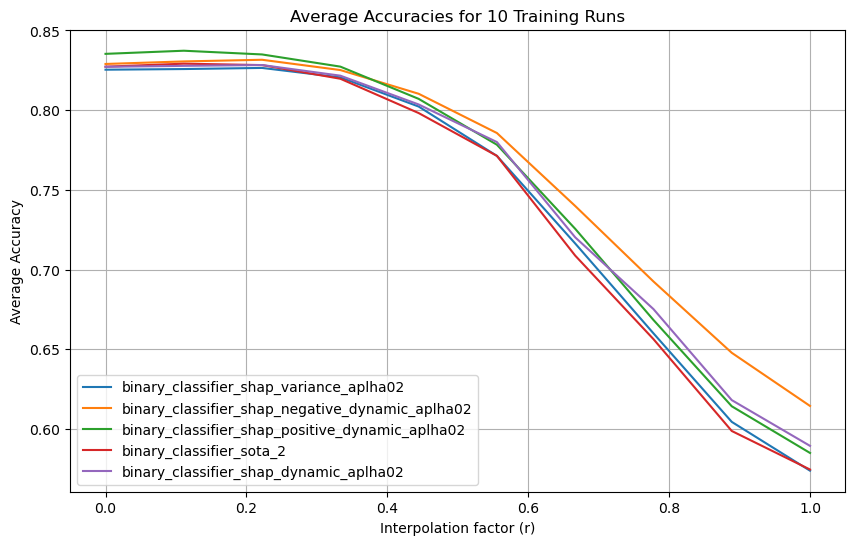

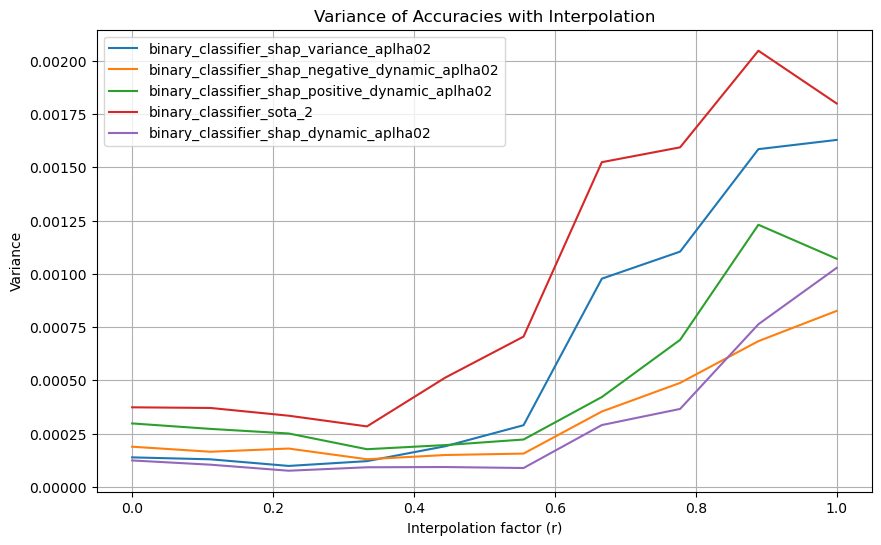

In [49]:
import os
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Interpolation with provided noise
def interpolate_with_given_noise(data, r, noise):
    return (1 - r) * data + r * noise

# Evaluation function
def evaluate_model_on_interpolated_data(data, true_labels, model, device, r, noise):
    interpolated_data = interpolate_with_given_noise(data, r, noise)
    interpolated_data = torch.tensor(interpolated_data, dtype=torch.float32).to(device)

    with torch.no_grad():
        predictions = model(interpolated_data)

    predicted_labels = (predictions > 0.5).float().cpu().numpy()
    return accuracy_score(true_labels, predicted_labels)

# Directory containing all model type folders
base_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/Notebooks/dynamic_values"

# List all model type folders
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(model_folders)

results = {}
variances = {}
r_values = np.linspace(0, 1, 10)

for r in r_values:
    # Generate noise once for this r-value, so every model gets the same noise
    noise = np.random.randn(*normalized_data.shape)

    for folder in model_folders:
        folder_path = os.path.join(base_dir, folder)

        accuracies = []
        # List all runs for this model type
        run_files = [f for f in os.listdir(folder_path) if f.endswith('.pth')]
        
        for run in run_files:
            model_path = os.path.join(folder_path, run)
            
            # Load the model
            model = Net()
            model.load_state_dict(torch.load(model_path))
            model.eval()
            model.to(device)

            accuracy = evaluate_model_on_interpolated_data(normalized_data, test_label, model, device, r, noise)
            accuracies.append(accuracy)
        
        # Store the average accuracy and variance for this r-value in the results
        results.setdefault(folder, []).append(np.mean(accuracies))
        variances.setdefault(folder, []).append(np.var(accuracies))

# Plot the average accuracies
plt.figure(figsize=(10, 6))
for model_type, accuracies in results.items():
    plt.plot(r_values, accuracies, label=model_type)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Average Accuracy")
plt.legend()
plt.grid(True)
plt.title("Average Accuracies for 10 Training Runs")
plt.show()

# Plot the variances
plt.figure(figsize=(10, 6))
for model_type, variance in variances.items():
    plt.plot(r_values, variance, label=model_type)
plt.xlabel("Interpolation factor (r)")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.title("Variance of Accuracies with Interpolation")
plt.show()


## Other Performance Metrics

In [ ]:
# Instantiate and load your models
model_dir = '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/saved_models_2.0/'  # specify your path
model_names = ['roofnet_binary_class_run3.pth', 'roofnet_binary_class_run3varbatch02.pth', 'roofnet_binary_class_avg5303posneg.pth', 'roofnet_binary_class_avg5303pos.pth', 'roofnet_binary_class_avg5303neg.pth']
models = []

for name in model_names:
    model = Net()
    model.load_state_dict(torch.load(model_dir + name))
    model.eval()
    model.to(device)
    models.append(model)

# Enable GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def get_predictions_and_probs(model, data):
    # Convert data to a tensor if it's not already one
    if not isinstance(data, torch.Tensor):
        data = torch.Tensor(data)
    
    # Move data to the same device as the model
    data = data.to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probabilities = torch.sigmoid(logits)
    
    predicted_labels = (probabilities > 0.5).float().cpu().numpy()
    predicted_probs = probabilities.cpu().numpy().squeeze()

    return predicted_labels, predicted_probs



for idx, model in enumerate(models):
    predicted_labels, predicted_probs = get_predictions_and_probs(model, test_hold)
    
    precision = precision_score(test_label, predicted_labels)
    recall = recall_score(test_label, predicted_labels)
    f1 = f1_score(test_label, predicted_labels)
    roc_auc = roc_auc_score(test_label, predicted_probs)
    
    print(f"Metrics for {model_names[idx]}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print("-" * 30)


## DATA CHECK 

In [ ]:
import matplotlib.pyplot as plt

# Extract the first and second latent dimensions
x = data_hold[:, 201]
y = data_hold[:, 200]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=label_hold, cmap='viridis', alpha=0.6)
plt.colorbar(label='Label Value')
plt.title('Visualization of the First Pair of Latents')
plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.grid(True)
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Compute variance for each feature
feature_variances = np.var(data_hold, axis=0)

# 2. Visualize feature variances
plt.figure(figsize=(15, 6))
plt.bar(range(256), feature_variances)
plt.title('Variance of Each Feature')
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.show()

# 3. Apply PCA
pca = PCA(n_components=256)  # Using all components for now
pca.fit(data_hold)

# Visualize variance explained by each principal component
explained_variances = pca.explained_variance_ratio_

plt.figure(figsize=(15, 6))
plt.bar(range(256), explained_variances)
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.show()

# Cumulative variance explained
cumulative_explained_variances = np.cumsum(explained_variances)

plt.figure(figsize=(15, 6))
plt.plot(range(256), cumulative_explained_variances, '-o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd

# Assuming data_hold is a 2D array, and we convert it into a DataFrame
df = pd.DataFrame(data_hold)

# Compute and print descriptive statistics
print(df.describe())

# Compute skewness and kurtosis
print("\nSkewness:\n", df.skew())
print("\nKurtosis:\n", df.kurtosis())


In [ ]:
import pandas as pd

# Convert data_hold into a DataFrame
df = pd.DataFrame(data_hold)

# Calculate the mean, median, skewness, and standard deviation
mean_values = df.mean()
median_values = df.median()
skewness_values = df.skew()
stdev_values = df.std()

# Print out the statistics for each feature
print("Mean Values:\n", mean_values)
print("\nMedian Values:\n", median_values)
print("\nSkewness Values:\n", skewness_values)
print("\nStandard Deviation Values:\n", stdev_values)


In [ ]:
import matplotlib.pyplot as plt

# Convert data_hold into a DataFrame (assuming it's a numpy array)
df = pd.DataFrame(data_hold)

# Calculate the mean, median, skewness, and standard deviation
mean_values = df.mean()
median_values = df.median()
skewness_values = df.skew()
stdev_values = df.std()

# Plot Mean, Median, and Standard Deviation
plt.figure(figsize=(14, 6))
plt.bar(mean_values.index, mean_values.values, alpha=0.6, label='Mean', color='blue')
plt.bar(median_values.index, median_values.values, alpha=0.6, label='Median', color='green')
plt.bar(stdev_values.index, stdev_values.values, alpha=0.6, label='Standard Deviation', color='red')
plt.legend()
plt.title("Mean, Median, and Standard Deviation of Features")
plt.xlabel("Features")
plt.ylabel("Value")
plt.show()

# Plot Skewness
plt.figure(figsize=(14, 6))
plt.bar(skewness_values.index, skewness_values.values, alpha=0.6, color='purple')
plt.title("Skewness of Features")
plt.xlabel("Features")
plt.ylabel("Skewness Value")
plt.axhline(0, color='black', linewidth=0.5)  # Add line at y=0 for reference
plt.show()


In [ ]:
import numpy as np

# Assuming data_hold is your dataset
means = np.mean(data_hold, axis=0)         # Mean of each feature
std_devs = np.std(data_hold, axis=0)       # Standard Deviation of each feature

# Avoid division by zero: Add a small value to means
means += 1e-10 

CVs = std_devs / means                      # Coefficient of Variation for each feature

print(CVs)


In [ ]:
import numpy as np

# Assuming data_hold is your dataset
means = np.mean(data_hold, axis=0)         # Mean of each feature
std_devs = np.std(data_hold, axis=0)       # Standard Deviation of each feature

# Avoid division by zero: Add a small value to means
means += 1e-10 

CVs = std_devs / means                      # Coefficient of Variation for each feature

# Define a threshold for what you consider a small CV
threshold = 0.1


# Count how many features have a CV below the threshold
num_small_CVs = np.sum(CVs <= threshold)

print(f"Number of features with CV < {threshold}: {num_small_CVs}")
